# Coursera Capstone Project

## Segmenting and Clustering Neighborhoods in Toronto - Part 1

### Part 1

# Table of Contents

<div class = "alert alert-block alert-info" style = "margin-top: 20px">

<font size = 3>

1.  <a href="#item1">Imports</a>

2.  <a href="#item2">Loading the data</a>

3.  <a href="#item3">Scraping the data</a>

4.  <a href="#item4">Data Wrangling</a>

5.  <a href="#item5">Loading Foursquare Credentials</a>  
    
6.  <a href="#item5">Getting Latitude and Longitude</a> 
    
7.  <a href="#item5">Pre Processing</a> 
    
8.  <a href="#item5">Loading Foursquare Credentials</a> 
    
9.  <a href="#item5">Loading Foursquare Credentials</a> 
    
    
    
    
    
    
    

</font>
</div>

# 1. Imports

In [1]:
!conda install --yes beautifulsoup4

!pip install lxml

!conda install -c conda-forge folium=0.5.0 --yes

!conda install -c conda-forge geopy --yes

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - beautifulsoup4


The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2020.6.2~ --> pkgs/main::ca-certificates-2020.10.14-0
  certifi            conda-forge/linux-64::certifi-2020.6.~ --> pkgs/main/noarch::certifi-2020.6.20-pyhd3eb1b0_3

The following packages will be SUPERSEDED by a higher-priority channel:

  openssl            conda-forge::openssl-1.1.1h-h516909a_0 --> pkgs/main::openssl-1.1.1h-h7b6447c_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2020.10.14~ --> conda-forge::ca-certificates-2020.6.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import silhouette_samples, silhouette_score

# import k-means from clustering stage
from sklearn.cluster import KMeans

from bs4 import BeautifulSoup
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# 2. Loading data

## 2.1 Loading Canada´s Postal code, Borough and Neighbourhood information

In [3]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text 
soup = BeautifulSoup(source, 'xml')
table = soup.find('table')

In [4]:
columns_names = ['Postalcode','Borough','Neighbourhood']
df = pd.DataFrame(columns = columns_names)


## 2.2 Loading the Geospatial Coordinates

In [5]:
dfgc = pd.read_csv('Geospatial_Coordinates.csv')
dfgc.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


# 3 Scraping the data

In [6]:
for tr in table.find_all('tr'):
    row_data=[]
    for td in tr.find_all('td'):
        row_data.append(td.text.strip())         
    if len(row_data)==3:
        df.loc[len(df)] = row_data


# 4 Data Wrangling

## 4.1 Replacing the "Not assigned" values in the Neighborhood column

In [7]:
for i in range(len(df)):
    if df['Neighbourhood'].loc[i] == 'Not assigned':
        a = df['Neighbourhood'].loc[i]
        b = df['Borough'].loc[i]
        df['Neighbourhood'].replace(a, b)

## 4.2. Replacing the "Not assigned" values in the Borough column

In [8]:
for i in range(len(df)):
    if df['Borough'].loc[i] == 'Not assigned':
        df = df.drop(i)

In [9]:
df = df.reset_index(drop = True) # prevent it to create a "column" named index

In [10]:
df.head()

,Postalcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [11]:
df.shape

(103, 3)

In [12]:
dfgc.rename(columns={'Postal Code' : 'Postalcode'}, inplace = True)

## 4.3 Merge the columns

In [13]:
fulldf = pd.merge(df, dfgc, left_on = 'Postalcode', right_on = 'Postalcode')
fulldf.head()

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [14]:
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

## 4.4 Creating a new Dataframe

In [15]:
toronto_data = fulldf.copy()
toronto_data.reset_index(drop = True)
toronto_data.drop(['Postalcode'], axis =1, inplace = True)
toronto_data.drop(['Borough'], axis = 1, inplace = True)
toronto_data.head()

,Neighbourhood,Latitude,Longitude
0,Parkwoods,43.753259,-79.329656
1,Victoria Village,43.725882,-79.315572
2,"Regent Park, Harbourfront",43.654260,-79.360636
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


# 5 Loading Foursquare Credentials

In [16]:
CLIENT_ID = 'PTV35CIWXLTOOCIXRYDULHNVIAQPAE10FGHHFXJPDG3HBQ3A' # your Foursquare ID
CLIENT_SECRET = 'KCZDBW50A30RK0QPWO23T4SI5DCEBWMWJM5CMJ015K24I3RC' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PTV35CIWXLTOOCIXRYDULHNVIAQPAE10FGHHFXJPDG3HBQ3A
CLIENT_SECRET:KCZDBW50A30RK0QPWO23T4SI5DCEBWMWJM5CMJ015K24I3RC


# 6 Getting Latitude and Longitude

In [17]:
address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of North York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of North York are 43.6534817, -79.3839347.


# 7 Pre Processing

In [18]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

## Analyze Neighborhood

In [22]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Organic Grocery,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Social Club,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [23]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Organic Grocery,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Social Club,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [24]:
# Let's put that into a pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Skating Rink,Clothing Store,Dim Sum Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Pharmacy,Coffee Shop,Pub,Gym,Airport Service,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Chinese Restaurant,Shopping Mall,Sandwich Place,Diner,Restaurant,Deli / Bodega,Supermarket
3,Bayview Village,Bank,Chinese Restaurant,Japanese Restaurant,Café,Yoga Studio,Dim Sum Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Thai Restaurant,Pharmacy,Pizza Place,Pub,Café,Restaurant,Butcher


In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Skating Rink,Clothing Store,Dim Sum Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Pharmacy,Coffee Shop,Pub,Gym,Airport Service,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Chinese Restaurant,Shopping Mall,Sandwich Place,Diner,Restaurant,Deli / Bodega,Supermarket
3,Bayview Village,Bank,Chinese Restaurant,Japanese Restaurant,Café,Yoga Studio,Dim Sum Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Thai Restaurant,Pharmacy,Pizza Place,Pub,Café,Restaurant,Butcher


# 8 Clustering Neighborhoods

In [27]:
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

In [28]:
def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

## 8.1 Finding the Best K

In [29]:
max_range = 15 #Max range 15 (number of clusters)

indices = []
scores = []

for toronto_clusters in range(2, max_range) :
    
    # Run k-means clustering
    toronto_gc = toronto_grouped_clustering
    kmeans = KMeans(n_clusters = toronto_clusters, init = 'k-means++', random_state = 0).fit_predict(toronto_gc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(toronto_gc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(toronto_clusters)
    scores.append(score)

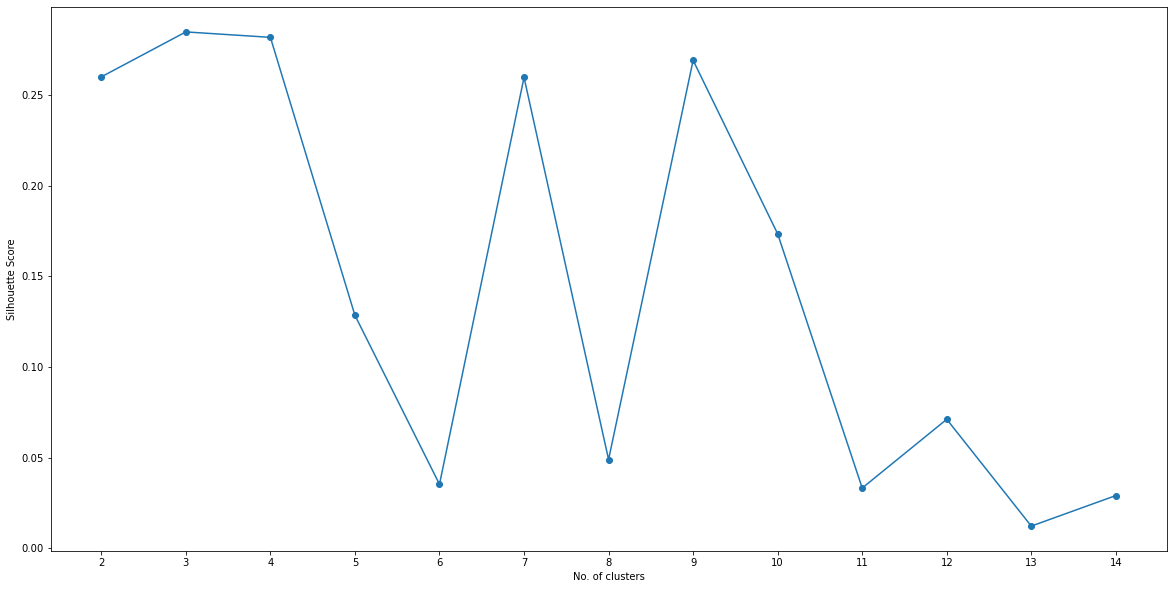

In [30]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [31]:
opt_value = 13

## 8.2 Using the Best K

In [32]:
toronto_clusters = opt_value

# Run k-means clustering
toronto_gc = toronto_grouped_clustering
kmeans = KMeans(n_clusters = toronto_clusters, init = 'k-means++', random_state = 0).fit(toronto_gc)

In [33]:
# Add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [34]:
toronto_final = toronto_data
toronto_final = toronto_final.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
toronto_final.dropna(inplace = True)
toronto_final['Cluster Labels'] = toronto_final['Cluster Labels'].astype(int)
toronto_final.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,43.753259,-79.329656,10,Park,Food & Drink Shop,Yoga Studio,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
1,Victoria Village,43.725882,-79.315572,2,Pizza Place,Coffee Shop,Hockey Arena,Portuguese Restaurant,Intersection,Drugstore,Donut Shop,Dumpling Restaurant,Deli / Bodega,Distribution Center
2,"Regent Park, Harbourfront",43.654260,-79.360636,5,Coffee Shop,Park,Bakery,Breakfast Spot,Theater,Chocolate Shop,Distribution Center,Spa,Farmers Market,Dessert Shop
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2,Clothing Store,Accessories Store,Boutique,Gift Shop,Furniture / Home Store,Event Space,Coffee Shop,Women's Store,Vietnamese Restaurant,Airport Terminal
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,5,Coffee Shop,Yoga Studio,Diner,Sandwich Place,Portuguese Restaurant,Park,Mexican Restaurant,Italian Restaurant,Hobby Shop,Fried Chicken Joint


In [35]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# Setup color scheme for different clusters
x = np.arange(toronto_clusters)
ys = [i + x + (i*x)**2 for i in range(toronto_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_final['Latitude'], toronto_final['Longitude'], toronto_final['Neighbourhood'], 
                                  toronto_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster + 1) + ')', parse_html=True)
    map_clusters.add_child(
        folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7))
       
map_clusters

## 9 Analyzing the clusters

In [36]:
val = 1
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Glencairn,Pizza Place,Park,Pub,Bakery,Japanese Restaurant,Department Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
49,"North Park, Maple Leaf Park, Upwood Park",Park,Construction & Landscaping,Bakery,Yoga Studio,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore
85,"Milliken, Agincourt North, Steeles East, L'Amo...",Playground,Park,Bakery,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop


In [37]:
val = 2
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Woburn,Coffee Shop,Korean BBQ Restaurant,Mexican Restaurant,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
51,"Cliffside, Cliffcrest, Scarborough Village West",American Restaurant,Motel,Yoga Studio,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop


In [38]:
val = 3
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,Pizza Place,Coffee Shop,Hockey Arena,Portuguese Restaurant,Intersection,Drugstore,Donut Shop,Dumpling Restaurant,Deli / Bodega,Distribution Center
3,"Lawrence Manor, Lawrence Heights",Clothing Store,Accessories Store,Boutique,Gift Shop,Furniture / Home Store,Event Space,Coffee Shop,Women's Store,Vietnamese Restaurant,Airport Terminal
8,"Parkview Hill, Woodbine Gardens",Pizza Place,Gastropub,Pharmacy,Bus Line,Breakfast Spot,Bank,Intersection,Athletics & Sports,Pet Store,Gym / Fitness Center
16,Humewood-Cedarvale,Tennis Court,Field,Hockey Arena,Trail,Dog Run,Dumpling Restaurant,Drugstore,Donut Shop,Deli / Bodega,Distribution Center
18,"Guildwood, Morningside, West Hill",Electronics Store,Bank,Restaurant,Rental Car Location,Intersection,Medical Center,Breakfast Spot,Mexican Restaurant,Donut Shop,Dog Run
23,Leaside,Coffee Shop,Sporting Goods Shop,Furniture / Home Store,Bank,Burger Joint,Shopping Mall,Supermarket,Sports Bar,Beer Store,Bike Shop
26,Cedarbrae,Caribbean Restaurant,Hakka Restaurant,Athletics & Sports,Thai Restaurant,Bakery,Bank,Fried Chicken Joint,Gas Station,Discount Store,Dim Sum Restaurant
27,Hillcrest Village,Athletics & Sports,Golf Course,Pool,Mediterranean Restaurant,Dog Run,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore
28,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Chinese Restaurant,Shopping Mall,Sandwich Place,Diner,Restaurant,Deli / Bodega,Supermarket
29,Thorncliffe Park,Sandwich Place,Indian Restaurant,Supermarket,Restaurant,Pizza Place,Pharmacy,Park,Middle Eastern Restaurant,Liquor Store,Intersection


In [39]:
val = 4
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Malvern, Rouge",Fast Food Restaurant,Yoga Studio,Event Space,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Dog Run


In [40]:
val = 5
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,"York Mills, Silver Hills",Martial Arts School,Yoga Studio,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Dog Run


In [41]:
val = 6
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Regent Park, Harbourfront",Coffee Shop,Park,Bakery,Breakfast Spot,Theater,Chocolate Shop,Distribution Center,Spa,Farmers Market,Dessert Shop
4,"Queen's Park, Ontario Provincial Government",Coffee Shop,Yoga Studio,Diner,Sandwich Place,Portuguese Restaurant,Park,Mexican Restaurant,Italian Restaurant,Hobby Shop,Fried Chicken Joint
7,Don Mills,Gym,Beer Store,Coffee Shop,Japanese Restaurant,Café,Supermarket,Dim Sum Restaurant,Restaurant,Caribbean Restaurant,Discount Store
9,"Garden District, Ryerson",Café,Coffee Shop,Clothing Store,Theater,Ramen Restaurant,Burrito Place,Sporting Goods Shop,Electronics Store,Shopping Mall,Sandwich Place
13,Don Mills,Gym,Beer Store,Coffee Shop,Japanese Restaurant,Café,Supermarket,Dim Sum Restaurant,Restaurant,Caribbean Restaurant,Discount Store
15,St. James Town,Gastropub,Farmers Market,Café,Restaurant,Japanese Restaurant,Coffee Shop,Gym,Thai Restaurant,Diner,Camera Store
17,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",Pizza Place,Beer Store,Coffee Shop,Convenience Store,Café,Shopping Plaza,Liquor Store,Pharmacy,Dance Studio,Donut Shop
20,Berczy Park,Coffee Shop,Seafood Restaurant,Farmers Market,Beer Bar,Cocktail Bar,Comfort Food Restaurant,French Restaurant,Breakfast Spot,Restaurant,Bistro
24,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Yoga Studio,Tea Room,Sandwich Place,Bubble Tea Shop,Spa,Japanese Restaurant,Ramen Restaurant
25,Christie,Grocery Store,Café,Park,Candy Store,Coffee Shop,Restaurant,Italian Restaurant,Athletics & Sports,Baby Store,Nightclub


In [42]:
val = 7
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,"Humberlea, Emery",Baseball Field,Yoga Studio,Falafel Restaurant,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
101,"Old Mill South, King's Mill Park, Sunnylea, Hu...",Construction & Landscaping,Baseball Field,Yoga Studio,Dim Sum Restaurant,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore


In [43]:
val = 8
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Woodbine Heights,Skating Rink,Intersection,Curling Ice,Park,Athletics & Sports,Beer Store,Dance Studio,Discount Store,Distribution Center,Dog Run
19,The Beaches,Neighborhood,Pub,Health Food Store,Trail,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
40,Downsview,Grocery Store,Park,Liquor Store,Bank,Baseball Field,Food Truck,Hotel,Home Service,Athletics & Sports,Business Service
44,"Golden Mile, Clairlea, Oakridge",Bus Line,Bakery,Park,Soccer Field,Bus Station,Intersection,Metro Station,Ice Cream Shop,Creperie,Cuban Restaurant
46,Downsview,Grocery Store,Park,Liquor Store,Bank,Baseball Field,Food Truck,Hotel,Home Service,Athletics & Sports,Business Service
53,Downsview,Grocery Store,Park,Liquor Store,Bank,Baseball Field,Food Truck,Hotel,Home Service,Athletics & Sports,Business Service
60,Downsview,Grocery Store,Park,Liquor Store,Bank,Baseball Field,Food Truck,Hotel,Home Service,Athletics & Sports,Business Service
61,Lawrence Park,Park,Swim School,Bus Line,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
63,"Runnymede, The Junction North",Breakfast Spot,Convenience Store,Brewery,Bus Line,Yoga Studio,Diner,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
67,Davisville North,Dog Run,Food & Drink Shop,Dance Studio,Sandwich Place,Hotel,Department Store,Park,Gym / Fitness Center,Breakfast Spot,Dumpling Restaurant


In [44]:
val = 9
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Roselawn,Music Venue,Garden,Yoga Studio,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop


In [45]:
val = 10
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
98,"The Kingsway, Montgomery Road, Old Mill North",Pool,River,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Dog Run


In [46]:
val = 11
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Park,Food & Drink Shop,Yoga Studio,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
21,Caledonia-Fairbanks,Park,Women's Store,Pool,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
35,"East Toronto, Broadview North (Old East York)",Park,Convenience Store,Intersection,Yoga Studio,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore
64,Weston,Park,Yoga Studio,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Dog Run
66,York Mills West,Park,Convenience Store,Yoga Studio,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
91,Rosedale,Park,Trail,Playground,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Donut Shop


In [47]:
val = 12
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"West Deane Park, Princess Gardens, Martin Grov...",Print Shop,Yoga Studio,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Dog Run


In [48]:
val = 13
toronto_final.loc[toronto_final['Cluster Labels'] == (val - 1), toronto_final.columns[[0] + np.arange(4, toronto_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Rouge Hill, Port Union, Highland Creek",Construction & Landscaping,Bar,Yoga Studio,Dim Sum Restaurant,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore
94,"Northwest, West Humber - Clairville",Drugstore,Bar,Garden Center,Rental Car Location,Yoga Studio,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
